# DEEP LEARNING Assignement 1
### Jennifer VIAL

## Instruction part  

Import libraries:

In [171]:
import keras
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from keras.layers import Dropout
import keras.utils
from keras import utils as np_utils
from keras.layers import UpSampling2D

Follow the instruction:

In [3]:
# On some implementations of matplotlib, you may need to change this value
IMAGE_SIZE = 72

In [4]:
def generate_a_drawing(figsize, U, V, noise=0.0):
    fig = plt.figure(figsize=(figsize,figsize))
    ax = plt.subplot(111)
    plt.axis('Off')
    ax.set_xlim(0,figsize)
    ax.set_ylim(0,figsize)
    ax.fill(U, V, "k")
    fig.canvas.draw()
    imdata = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)[::3].astype(np.float32)
    imdata = imdata + noise * np.random.random(imdata.size)
    plt.close(fig)
    return imdata

In [5]:
def generate_a_rectangle(noise=0.0, free_location=False):
    figsize = 1.0    
    U = np.zeros(4)
    V = np.zeros(4)
    if free_location:
        corners = np.random.random(4)
        top = max(corners[0], corners[1])
        bottom = min(corners[0], corners[1])
        left = min(corners[2], corners[3])
        right = max(corners[2], corners[3])
    else:
        side = (0.3 + 0.7 * np.random.random()) * figsize
        top = figsize/2 + side/2
        bottom = figsize/2 - side/2
        left = bottom
        right = top
    U[0] = U[1] = top
    U[2] = U[3] = bottom
    V[0] = V[3] = left
    V[1] = V[2] = right
    return generate_a_drawing(figsize, U, V, noise)

In [6]:
def generate_a_disk(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        center = np.random.random(2)
    else:
        center = (figsize/2, figsize/2)
    radius = (0.3 + 0.7 * np.random.random()) * figsize/2
    N = 50
    U = np.zeros(N)
    V = np.zeros(N)
    i = 0
    for t in np.linspace(0, 2*np.pi, N):
        U[i] = center[0] + np.cos(t) * radius
        V[i] = center[1] + np.sin(t) * radius
        i = i + 1
    return generate_a_drawing(figsize, U, V, noise)


In [7]:
def generate_a_triangle(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        U = np.random.random(3)
        V = np.random.random(3)
    else:
        size = (0.3 + 0.7 * np.random.random())*figsize/2
        middle = figsize/2
        U = (middle, middle+size, middle-size)
        V = (middle+size, middle-size, middle-size)
    imdata = generate_a_drawing(figsize, U, V, noise)
    return [imdata, [U[0], V[0], U[1], V[1], U[2], V[2]]]

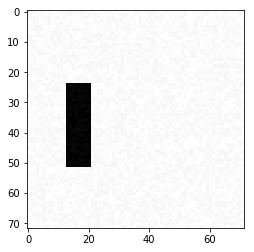

In [8]:
im = generate_a_rectangle(10, True)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')



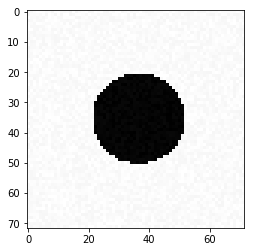

In [9]:
im = generate_a_disk(10)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

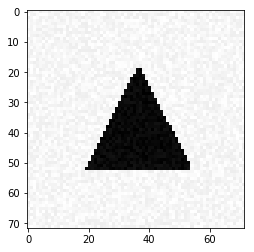

In [10]:
[im, v] = generate_a_triangle(20, False)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

In [11]:
def generate_dataset_classification(nb_samples, noise=0.0, free_location=False):
    # Getting im_size:
    im_size = generate_a_rectangle().shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros(nb_samples)
    print('Creating data:')
    for i in range(nb_samples):
        if i % 10 == 0:
            print(i)
        category = np.random.randint(3)
        if category == 0:
            X[i] = generate_a_rectangle(noise, free_location)
        elif category == 1: 
            X[i] = generate_a_disk(noise, free_location)
        else:
            [X[i], V] = generate_a_triangle(noise, free_location)
        Y[i] = category
    X = (X + noise) / (255 + 2 * noise)
    return [X, Y]

def generate_test_set_classification():
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_classification(300, 20, True)
    Y_test = np_utils.to_categorical(Y_test, 3) 
    return [X_test, Y_test]

def generate_dataset_regression(nb_samples, noise=0.0):
    # Getting im_size:
    im_size = generate_a_triangle()[0].shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros([nb_samples, 6])
    print('Creating data:')
    for i in range(nb_samples):
        if i % 10 == 0:
            print(i)
        [X[i], Y[i]] = generate_a_triangle(noise, True)
    X = (X + noise) / (255 + 2 * noise)
    return [X, Y]

import matplotlib.patches as patches

def visualize_prediction(x, y):
    fig, ax = plt.subplots(figsize=(5, 5))
    I = x.reshape((IMAGE_SIZE,IMAGE_SIZE))
    ax.imshow(I, extent=[-0.15,1.15,-0.15,1.15],cmap='gray')
    ax.set_xlim([0,1])
    ax.set_ylim([0,1])

    xy = y.reshape(3,2)
    tri = patches.Polygon(xy, closed=True, fill = False, edgecolor = 'r', linewidth = 5, alpha = 0.5)
    ax.add_patch(tri)

    plt.show()

def generate_test_set_regression():
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_regression(300, 20)
    return [X_test, Y_test]



Generate a training set of images of simple geometric shapes:

In [12]:
[X_train, Y_train] = generate_dataset_classification(300, 20)

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


In [13]:
Y_train = keras.utils.to_categorical(Y_train, 3)

## Build and train a linear classifier in Keras to classify a image into one of the three possible categories

With the stochastic gradient descent optimizer:

In [14]:
from keras.models import Sequential
from keras.layers import Dense, Activation

Define our model: 

In [84]:
model = Sequential()
model.add(Dense(units=32,kernel_initializer= 'uniform',activation="relu", input_shape=(X_train.shape[1],)))
model.add(Dropout(rate=0.2))
model.add(Dense(units=10,kernel_initializer= 'uniform',activation="relu"))
model.add(Dropout(rate=0.2))
model.add(Dense(units=3,kernel_initializer= 'uniform',activation="softmax"))

In [85]:
from keras.optimizers import SGD

Define the gradient optimzer and compile with our model:

In [86]:
sgd = SGD(lr=0.01,decay=1e-6, momentum=0.9,nesterov=True)
model.compile(loss='categorical_crossentropy',optimizer=sgd, metrics=["accuracy"])

In [88]:
model.fit(X_train, Y_train, epochs=200, batch_size=32)

Epoch 1/200
300/300 [==============================] - 0s 176us/step - loss: 0.7502 - acc: 0.5633
Epoch 2/200
300/300 [==============================] - 0s 176us/step - loss: 0.7388 - acc: 0.5867
Epoch 3/200
300/300 [==============================] - 0s 179us/step - loss: 0.6509 - acc: 0.6067
Epoch 4/200
300/300 [==============================] - 0s 184us/step - loss: 0.7146 - acc: 0.5967
Epoch 5/200
300/300 [==============================] - 0s 183us/step - loss: 0.6783 - acc: 0.6333
Epoch 6/200
300/300 [==============================] - 0s 184us/step - loss: 0.7606 - acc: 0.5733
Epoch 7/200
300/300 [==============================] - 0s 183us/step - loss: 0.6877 - acc: 0.6067
Epoch 8/200
300/300 [==============================] - 0s 182us/step - loss: 0.6921 - acc: 0.6100
Epoch 9/200
300/300 [==============================] - 0s 175us/step - loss: 0.7183 - acc: 0.5733
Epoch 10/200
300/300 [==============================] - 0s 195us/step - loss: 0.6540 - acc: 0.5867
Epoch 11/200
300/30

300/300 [==============================] - 0s 247us/step - loss: 0.7455 - acc: 0.5800
Epoch 84/200
300/300 [==============================] - 0s 259us/step - loss: 0.6441 - acc: 0.5900
Epoch 85/200
300/300 [==============================] - 0s 278us/step - loss: 0.7111 - acc: 0.5900
Epoch 86/200
300/300 [==============================] - 0s 231us/step - loss: 0.7633 - acc: 0.5433
Epoch 87/200
300/300 [==============================] - 0s 279us/step - loss: 0.6753 - acc: 0.6100
Epoch 88/200
300/300 [==============================] - 0s 296us/step - loss: 0.6982 - acc: 0.5800
Epoch 89/200
300/300 [==============================] - 0s 295us/step - loss: 0.6930 - acc: 0.6033
Epoch 90/200
300/300 [==============================] - 0s 292us/step - loss: 0.7000 - acc: 0.6000
Epoch 91/200
300/300 [==============================] - 0s 302us/step - loss: 0.7622 - acc: 0.5733
Epoch 92/200
300/300 [==============================] - 0s 290us/step - loss: 0.6583 - acc: 0.6000
Epoch 93/200
300/300 [=

300/300 [==============================] - 0s 166us/step - loss: 0.6898 - acc: 0.6033
Epoch 166/200
300/300 [==============================] - 0s 172us/step - loss: 0.7727 - acc: 0.5700
Epoch 167/200
300/300 [==============================] - 0s 189us/step - loss: 0.7078 - acc: 0.5967
Epoch 168/200
300/300 [==============================] - 0s 179us/step - loss: 0.7055 - acc: 0.5967
Epoch 169/200
300/300 [==============================] - 0s 181us/step - loss: 0.7154 - acc: 0.5933
Epoch 170/200
300/300 [==============================] - 0s 190us/step - loss: 0.7229 - acc: 0.5900
Epoch 171/200
300/300 [==============================] - 0s 202us/step - loss: 0.7609 - acc: 0.5733
Epoch 172/200
300/300 [==============================] - 0s 172us/step - loss: 0.7211 - acc: 0.5900
Epoch 173/200
300/300 [==============================] - 0s 164us/step - loss: 0.6767 - acc: 0.6100
Epoch 174/200
300/300 [==============================] - 0s 169us/step - loss: 0.6984 - acc: 0.6000
Epoch 175/200


Check our classifier: 

In [89]:
X_test = generate_a_disk()
X_test = X_test.reshape(1, X_test.shape[0])
model.predict(X_test)

array([[0.47047248, 0.447174  , 0.08235354]], dtype=float32)

In [90]:
[X_test, Y_test] = generate_dataset_classification(300, 20)

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


In [91]:
Y_test=keras.utils.to_categorical(Y_test, 3)

In [92]:
model.evaluate(X_test, Y_test)

300/300 [==============================] - 0s 491us/step


[0.5451261878013611, 0.6266666666666667]

With Adam optimizer:

In [138]:
model2 = Sequential()
model2.add(Dense(units=3,kernel_initializer= 'uniform',activation="softmax", input_shape=(X_train.shape[1],)))

In [139]:
from keras import optimizers

In [140]:
adam=optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model2.compile(loss='categorical_crossentropy',optimizer='adam')

In [141]:
model2.fit(X_train, Y_train, epochs=200, batch_size=32)

Epoch 1/200
300/300 [==============================] - 0s 2ms/step - loss: 1.7185
Epoch 2/200
300/300 [==============================] - 0s 152us/step - loss: 0.7638
Epoch 3/200
300/300 [==============================] - 0s 153us/step - loss: 0.4973
Epoch 4/200
300/300 [==============================] - 0s 147us/step - loss: 0.3501
Epoch 5/200
300/300 [==============================] - 0s 132us/step - loss: 0.3496
Epoch 6/200
300/300 [==============================] - 0s 144us/step - loss: 0.3632
Epoch 7/200
300/300 [==============================] - 0s 148us/step - loss: 0.2864
Epoch 8/200
300/300 [==============================] - 0s 143us/step - loss: 0.1781
Epoch 9/200
300/300 [==============================] - 0s 145us/step - loss: 0.1658
Epoch 10/200
300/300 [==============================] - 0s 151us/step - loss: 0.1723
Epoch 11/200
300/300 [==============================] - 0s 150us/step - loss: 0.1774
Epoch 12/200
300/300 [==============================] - 0s 136us/step - loss

300/300 [==============================] - 0s 139us/step - loss: 0.0066
Epoch 98/200
300/300 [==============================] - 0s 138us/step - loss: 0.0067
Epoch 99/200
300/300 [==============================] - 0s 156us/step - loss: 0.0066
Epoch 100/200
300/300 [==============================] - 0s 146us/step - loss: 0.0066
Epoch 101/200
300/300 [==============================] - 0s 148us/step - loss: 0.0066
Epoch 102/200
300/300 [==============================] - 0s 140us/step - loss: 0.0061
Epoch 103/200
300/300 [==============================] - 0s 130us/step - loss: 0.0063
Epoch 104/200
300/300 [==============================] - 0s 144us/step - loss: 0.0059
Epoch 105/200
300/300 [==============================] - 0s 137us/step - loss: 0.0060
Epoch 106/200
300/300 [==============================] - 0s 140us/step - loss: 0.0058
Epoch 107/200
300/300 [==============================] - 0s 143us/step - loss: 0.0060
Epoch 108/200
300/300 [==============================] - 0s 144us/step

300/300 [==============================] - 0s 130us/step - loss: 0.0021
Epoch 193/200
300/300 [==============================] - 0s 132us/step - loss: 0.0021
Epoch 194/200
300/300 [==============================] - 0s 128us/step - loss: 0.0021
Epoch 195/200
300/300 [==============================] - 0s 145us/step - loss: 0.0021
Epoch 196/200
300/300 [==============================] - 0s 134us/step - loss: 0.0021
Epoch 197/200
300/300 [==============================] - 0s 138us/step - loss: 0.0020
Epoch 198/200
300/300 [==============================] - 0s 127us/step - loss: 0.0020
Epoch 199/200
300/300 [==============================] - 0s 132us/step - loss: 0.0020
Epoch 200/200
300/300 [==============================] - 0s 135us/step - loss: 0.0019


In [142]:
X_test = generate_a_disk()
X_test = X_test.reshape(1, X_test.shape[0])
model2.predict(X_test)

array([[0., 1., 0.]], dtype=float32)

## Visualization of the Solution

##### Visualization for SGD:

Check the output of the function model.get_weights():

In [143]:
model.get_weights()

[array([[-5.1517945e-02,  2.7449455e-02,  2.8909747e-02, ...,
          1.4621785e-02, -1.9878542e-02,  2.9065978e-02],
        [-3.0549543e-02,  4.5202006e-02, -1.9858071e-05, ...,
         -1.3066895e-02,  4.7969561e-02, -1.9068969e-02],
        [-2.8820513e-02, -1.1046063e-02, -1.8792763e-02, ...,
          4.6519581e-02, -2.6659714e-02,  3.3103004e-03],
        ...,
        [-3.8516533e-02,  4.7398414e-02,  2.2087669e-02, ...,
          9.1711860e-03, -3.6247537e-02, -3.2124091e-02],
        [-8.3463686e-03,  2.0117950e-02, -5.1407501e-02, ...,
         -2.1652434e-02,  2.2588437e-02,  1.9854512e-02],
        [ 4.2053279e-02,  2.9147658e-02, -4.6910673e-02, ...,
         -3.4474149e-02,  4.4202499e-02, -2.5266076e-02]], dtype=float32),
 array([-6.73523825e-03,  0.00000000e+00, -1.88472606e-02, -7.21660443e-04,
        -2.23093256e-02, -2.33232812e-03, -2.89513147e-03, -1.68305784e-02,
        -2.77567049e-03, -2.68904958e-03, -6.58369763e-03,  0.00000000e+00,
        -5.84846130e-0

In [144]:
A=model.get_weights()[0]

In [145]:
im1=A[:,0]
im2=A[:,1]
im3=A[:,2]

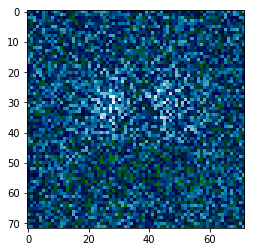

In [146]:
plt.imshow(im1.reshape(IMAGE_SIZE, IMAGE_SIZE), interpolation='nearest', cmap='ocean')

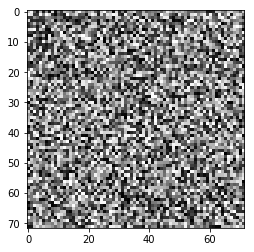

In [147]:
plt.imshow(im2.reshape(IMAGE_SIZE, IMAGE_SIZE), interpolation='nearest', cmap='gray')

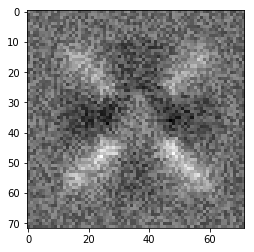

In [148]:
plt.imshow(im3.reshape(IMAGE_SIZE, IMAGE_SIZE), interpolation='nearest', cmap='gray')

##### Visualization for Adam:

In [149]:
model2.get_weights()

[array([[-0.04434911, -0.004837  ,  0.01013964],
        [ 0.03799769, -0.00301278,  0.04063138],
        [-0.02456405,  0.0209684 , -0.05095705],
        ...,
        [ 0.03828674, -0.04931716, -0.04815431],
        [-0.04049332, -0.02818363, -0.03862282],
        [ 0.00342622,  0.03005443, -0.0019228 ]], dtype=float32),
 array([ 0.00220232, -0.00081152, -0.00131947], dtype=float32)]

In [150]:
A2=model2.get_weights()[0]

In [151]:
im4=A2[:,0]
im5=A2[:,1]
im6=A2[:,2]

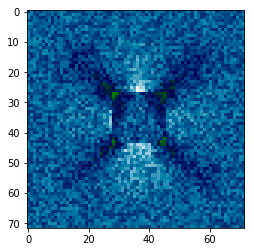

In [152]:
plt.imshow(im4.reshape(IMAGE_SIZE, IMAGE_SIZE), cmap='ocean')

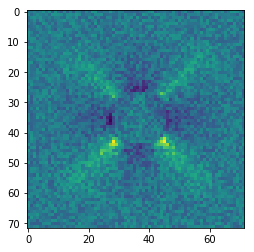

In [153]:
plt.imshow(im5.reshape(IMAGE_SIZE, IMAGE_SIZE), interpolation='nearest')

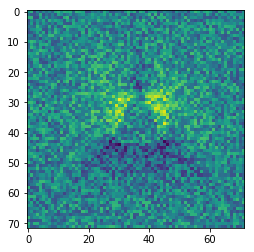

In [154]:
plt.imshow(im6.reshape(IMAGE_SIZE, IMAGE_SIZE), interpolation='nearest')

# A more difficult classicification problem 

In [155]:
[X_train5, Y_train5] = generate_dataset_classification(300, 20, True)
Y_trainc5 = keras.utils.to_categorical(Y_train5, 3)

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


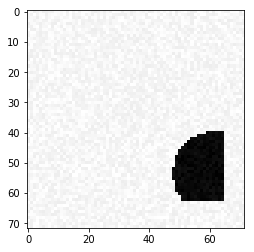

In [156]:
plt.imshow(X_train5[280].reshape(IMAGE_SIZE, IMAGE_SIZE), cmap='gray')

In [160]:
model51 = Sequential()
model51.add(Dense(units=32,kernel_initializer= 'uniform',activation="relu", input_shape=(X_train.shape[1],)))
model51.add(Dropout(rate=0.2))
model51.add(Dense(units=10,kernel_initializer= 'uniform',activation="relu"))
model51.add(Dropout(rate=0.2))
model51.add(Dense(units=3,kernel_initializer= 'uniform',activation="softmax"))



In [161]:
sgd = SGD(lr=0.01,decay=1e-6, momentum=0.9,nesterov=True)
model51.compile(loss='categorical_crossentropy',optimizer=sgd, metrics=["accuracy"])

In [162]:
model51.fit(X_train5, Y_trainc5, epochs=200, batch_size=32)

Epoch 1/200
300/300 [==============================] - 1s 2ms/step - loss: 1.0983 - acc: 0.3567
Epoch 2/200
300/300 [==============================] - 0s 192us/step - loss: 1.0971 - acc: 0.3633
Epoch 3/200
300/300 [==============================] - 0s 190us/step - loss: 1.0964 - acc: 0.3600
Epoch 4/200
300/300 [==============================] - 0s 216us/step - loss: 1.0963 - acc: 0.3500
Epoch 5/200
300/300 [==============================] - 0s 195us/step - loss: 1.0947 - acc: 0.3500
Epoch 6/200
300/300 [==============================] - 0s 219us/step - loss: 1.0934 - acc: 0.3367
Epoch 7/200
300/300 [==============================] - 0s 200us/step - loss: 1.0900 - acc: 0.3600
Epoch 8/200
300/300 [==============================] - 0s 194us/step - loss: 1.0878 - acc: 0.3667
Epoch 9/200
300/300 [==============================] - 0s 195us/step - loss: 1.0813 - acc: 0.4033
Epoch 10/200
300/300 [==============================] - 0s 218us/step - loss: 1.0690 - acc: 0.4267
Epoch 11/200
300/300 

300/300 [==============================] - 0s 195us/step - loss: 1.0968 - acc: 0.3500
Epoch 84/200
300/300 [==============================] - 0s 202us/step - loss: 1.0969 - acc: 0.3733
Epoch 85/200
300/300 [==============================] - 0s 203us/step - loss: 1.0970 - acc: 0.3433
Epoch 86/200
300/300 [==============================] - 0s 193us/step - loss: 1.0968 - acc: 0.3533
Epoch 87/200
300/300 [==============================] - 0s 201us/step - loss: 1.0971 - acc: 0.3533
Epoch 88/200
300/300 [==============================] - 0s 193us/step - loss: 1.0970 - acc: 0.3600
Epoch 89/200
300/300 [==============================] - 0s 183us/step - loss: 1.0983 - acc: 0.3233
Epoch 90/200
300/300 [==============================] - 0s 184us/step - loss: 1.0962 - acc: 0.3567
Epoch 91/200
300/300 [==============================] - 0s 201us/step - loss: 1.0974 - acc: 0.3633
Epoch 92/200
300/300 [==============================] - 0s 232us/step - loss: 1.0962 - acc: 0.3600
Epoch 93/200
300/300 [=

300/300 [==============================] - 0s 189us/step - loss: 1.0976 - acc: 0.3533
Epoch 165/200
300/300 [==============================] - 0s 184us/step - loss: 1.0966 - acc: 0.3533
Epoch 166/200
300/300 [==============================] - 0s 202us/step - loss: 1.0968 - acc: 0.3533
Epoch 167/200
300/300 [==============================] - 0s 190us/step - loss: 1.0972 - acc: 0.3533
Epoch 168/200
300/300 [==============================] - 0s 190us/step - loss: 1.0967 - acc: 0.3533
Epoch 169/200
300/300 [==============================] - 0s 182us/step - loss: 1.0975 - acc: 0.3433
Epoch 170/200
300/300 [==============================] - 0s 190us/step - loss: 1.0969 - acc: 0.3433
Epoch 171/200
300/300 [==============================] - 0s 189us/step - loss: 1.0974 - acc: 0.3433
Epoch 172/200
300/300 [==============================] - 0s 197us/step - loss: 1.0968 - acc: 0.3533
Epoch 173/200
300/300 [==============================] - 0s 183us/step - loss: 1.0973 - acc: 0.3533
Epoch 174/200


In [166]:
[X_test5, Y_test5] = generate_test_set_classification()

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


Evaluating the model:

In [167]:
 model51.evaluate(X_test5, Y_test5)

300/300 [==============================] - 0s 872us/step


[1.0997201204299927, 0.34000000009934106]

Reshape X_train:

In [168]:
X_train5 = X_train5.reshape(X_train5.shape[0],72,72,1)

In [173]:
from keras.layers import MaxPooling2D
from keras.layers import Conv2D
from keras.layers import Flatten

Build the convolutional model:

In [174]:
model6 = Sequential()
model6.add(Conv2D(16, kernel_size=(5, 5), activation='relu', input_shape=(72,72,1)))
model6.add(MaxPooling2D(pool_size=(2, 2)))
model6.add(Flatten())
model6.add(Dense(70, activation='relu'))
model6.add(Dense(3, activation='sigmoid'))

In [175]:
model6.compile(loss='categorical_crossentropy',optimizer=sgd, metrics=["accuracy"])

In [176]:
model6.fit(X_train5, Y_trainc5, batch_size=12, epochs=9)

Epoch 1/9
300/300 [==============================] - 2s 6ms/step - loss: 1.0968 - acc: 0.3833
Epoch 2/9
300/300 [==============================] - 1s 4ms/step - loss: 1.0431 - acc: 0.5167
Epoch 3/9
300/300 [==============================] - 1s 5ms/step - loss: 0.9509 - acc: 0.5667
Epoch 4/9
300/300 [==============================] - 1s 5ms/step - loss: 0.8141 - acc: 0.6367
Epoch 5/9
300/300 [==============================] - 1s 5ms/step - loss: 0.7922 - acc: 0.6500
Epoch 6/9
300/300 [==============================] - 1s 5ms/step - loss: 0.6650 - acc: 0.7267
Epoch 7/9
300/300 [==============================] - 1s 5ms/step - loss: 0.5596 - acc: 0.7800
Epoch 8/9
300/300 [==============================] - 1s 5ms/step - loss: 0.3789 - acc: 0.8700
Epoch 9/9
300/300 [==============================] - 1s 4ms/step - loss: 0.2707 - acc: 0.9200


In [177]:
[X_test5, Y_test5] = generate_test_set_classification()

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


Evaluate the model:

In [178]:
model6.evaluate(X_train5, Y_trainc5)

300/300 [==============================] - 1s 3ms/step


[0.2124850700298945, 0.9566666666666667]

See the name of the metrics:

In [180]:
model6.metrics_names

['loss', 'acc']

# Regression problem

####  Predict the image locations of the vertices of a triangle

Generate a training set: 

In [181]:
[X_train, Y_train] = generate_dataset_regression(300, 20)

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


Visualize a training sample:

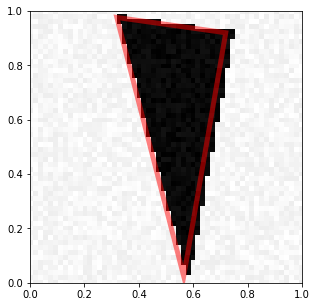

In [182]:
visualize_prediction(X_train[0], Y_train[0])

Generate the dataset regression: 

In [227]:
def generate_dataset_regression(nb_samples, noise=0.0):
    # Getting im_size:
    im_size = generate_a_triangle()[0].shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros([nb_samples, 6])
    print('Creating data:')
    for i in range(nb_samples):
        if i % 10 == 0:
            print(i)
        [X[i], Y[i]] = generate_a_triangle(noise, True)
    X = (X + noise) / (255 + 2 * noise)
    return [X, Y]

Create the definition visualize prediction: 

In [184]:
def visualize_prediction(x, y):
    fig, ax = plt.subplots(figsize=(5, 5))
    I = x.reshape((IMAGE_SIZE,IMAGE_SIZE))
    ax.imshow(I, extent=[-0.15,1.15,-0.15,1.15],cmap='gray')
    ax.set_xlim([0,1])
    ax.set_ylim([0,1])

    xy = y.reshape(3,2)
    print(xy)
    tri = patches.Polygon(xy, closed=True, fill = False, edgecolor = 'r', linewidth = 5, alpha = 0.5)
    ax.add_patch(tri)

    plt.show()

[[0.71986584 0.92000602]
 [0.31926686 0.97619732]
 [0.56522072 0.02423682]]


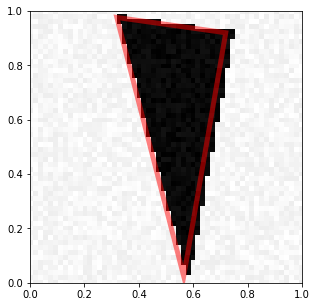

[0.71986584 0.92000602 0.31926686 0.97619732 0.56522072 0.02423682]


In [185]:
visualize_prediction(X_train[0], Y_train[0])
print(Y_train[0])

Generate the dataset regression:

In [187]:
[X_re, Y_re] = generate_dataset_regression(300, 20)

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


Modelize the regressor: 

In [189]:
regressor = Sequential()

In [190]:
regressor.add(Dense(units=130,kernel_initializer= 'uniform',activation="relu", input_shape=(5184,)))
regressor.add(Dropout(0.3))
regressor.add(Dense(units=130,kernel_initializer= 'uniform',activation="relu"))
regressor.add(Dropout(0.3))
regressor.add(Dense(units=6,kernel_initializer= 'uniform'))
regressor.compile(optimizer="adam", loss='mse', metrics= ["mse"])
history=regressor.fit(X_train,Y_train,validation_data=(X_re,Y_re),batch_size=32, epochs=300)

Train on 300 samples, validate on 300 samples
Epoch 1/300
300/300 [==============================] - 1s 3ms/step - loss: 0.1827 - mean_squared_error: 0.1827 - val_loss: 0.0891 - val_mean_squared_error: 0.0891
Epoch 2/300
300/300 [==============================] - 0s 739us/step - loss: 0.1211 - mean_squared_error: 0.1211 - val_loss: 0.1006 - val_mean_squared_error: 0.1006
Epoch 3/300
300/300 [==============================] - 0s 713us/step - loss: 0.1049 - mean_squared_error: 0.1049 - val_loss: 0.0851 - val_mean_squared_error: 0.0851
Epoch 4/300
300/300 [==============================] - 0s 730us/step - loss: 0.0970 - mean_squared_error: 0.0970 - val_loss: 0.0845 - val_mean_squared_error: 0.0845
Epoch 5/300
300/300 [==============================] - 0s 797us/step - loss: 0.0978 - mean_squared_error: 0.0978 - val_loss: 0.0932 - val_mean_squared_error: 0.0932
Epoch 6/300
300/300 [==============================] - 0s 768us/step - loss: 0.0915 - mean_squared_error: 0.0915 - val_loss: 0.0859

300/300 [==============================] - 0s 831us/step - loss: 0.0785 - mean_squared_error: 0.0785 - val_loss: 0.0880 - val_mean_squared_error: 0.0880
Epoch 51/300
300/300 [==============================] - 0s 886us/step - loss: 0.0770 - mean_squared_error: 0.0770 - val_loss: 0.0832 - val_mean_squared_error: 0.0832
Epoch 52/300
300/300 [==============================] - 0s 967us/step - loss: 0.0770 - mean_squared_error: 0.0770 - val_loss: 0.0782 - val_mean_squared_error: 0.0782
Epoch 53/300
300/300 [==============================] - 0s 860us/step - loss: 0.0762 - mean_squared_error: 0.0762 - val_loss: 0.0757 - val_mean_squared_error: 0.0757
Epoch 54/300
300/300 [==============================] - 0s 881us/step - loss: 0.0771 - mean_squared_error: 0.0771 - val_loss: 0.0806 - val_mean_squared_error: 0.0806
Epoch 55/300
300/300 [==============================] - 0s 803us/step - loss: 0.0780 - mean_squared_error: 0.0780 - val_loss: 0.0831 - val_mean_squared_error: 0.0831
Epoch 56/300
300/

300/300 [==============================] - 0s 826us/step - loss: 0.0713 - mean_squared_error: 0.0713 - val_loss: 0.0853 - val_mean_squared_error: 0.0853
Epoch 100/300
300/300 [==============================] - 0s 766us/step - loss: 0.0726 - mean_squared_error: 0.0726 - val_loss: 0.0762 - val_mean_squared_error: 0.0762
Epoch 101/300
300/300 [==============================] - 0s 887us/step - loss: 0.0711 - mean_squared_error: 0.0711 - val_loss: 0.0755 - val_mean_squared_error: 0.0755
Epoch 102/300
300/300 [==============================] - 0s 761us/step - loss: 0.0707 - mean_squared_error: 0.0707 - val_loss: 0.0763 - val_mean_squared_error: 0.0763
Epoch 103/300
300/300 [==============================] - 0s 799us/step - loss: 0.0711 - mean_squared_error: 0.0711 - val_loss: 0.0749 - val_mean_squared_error: 0.0749
Epoch 104/300
300/300 [==============================] - 0s 772us/step - loss: 0.0696 - mean_squared_error: 0.0696 - val_loss: 0.0748 - val_mean_squared_error: 0.0748
Epoch 105/30

300/300 [==============================] - 0s 878us/step - loss: 0.0685 - mean_squared_error: 0.0685 - val_loss: 0.0723 - val_mean_squared_error: 0.0723
Epoch 149/300
300/300 [==============================] - 0s 759us/step - loss: 0.0681 - mean_squared_error: 0.0681 - val_loss: 0.0725 - val_mean_squared_error: 0.0725
Epoch 150/300
300/300 [==============================] - 0s 916us/step - loss: 0.0675 - mean_squared_error: 0.0675 - val_loss: 0.0773 - val_mean_squared_error: 0.0773
Epoch 151/300
300/300 [==============================] - 0s 828us/step - loss: 0.0674 - mean_squared_error: 0.0674 - val_loss: 0.0731 - val_mean_squared_error: 0.0731
Epoch 152/300
300/300 [==============================] - 0s 781us/step - loss: 0.0677 - mean_squared_error: 0.0677 - val_loss: 0.0722 - val_mean_squared_error: 0.0722
Epoch 153/300
300/300 [==============================] - 0s 771us/step - loss: 0.0689 - mean_squared_error: 0.0689 - val_loss: 0.0714 - val_mean_squared_error: 0.0714
Epoch 154/30

300/300 [==============================] - 0s 859us/step - loss: 0.0666 - mean_squared_error: 0.0666 - val_loss: 0.0720 - val_mean_squared_error: 0.0720
Epoch 198/300
300/300 [==============================] - 0s 788us/step - loss: 0.0656 - mean_squared_error: 0.0656 - val_loss: 0.0722 - val_mean_squared_error: 0.0722
Epoch 199/300
300/300 [==============================] - 0s 821us/step - loss: 0.0704 - mean_squared_error: 0.0704 - val_loss: 0.0695 - val_mean_squared_error: 0.0695
Epoch 200/300
300/300 [==============================] - 0s 793us/step - loss: 0.0706 - mean_squared_error: 0.0706 - val_loss: 0.0766 - val_mean_squared_error: 0.0766
Epoch 201/300
300/300 [==============================] - 0s 729us/step - loss: 0.0705 - mean_squared_error: 0.0705 - val_loss: 0.0769 - val_mean_squared_error: 0.0769
Epoch 202/300
300/300 [==============================] - 0s 707us/step - loss: 0.0696 - mean_squared_error: 0.0696 - val_loss: 0.0747 - val_mean_squared_error: 0.0747
Epoch 203/30

300/300 [==============================] - 0s 741us/step - loss: 0.0668 - mean_squared_error: 0.0668 - val_loss: 0.0726 - val_mean_squared_error: 0.0726
Epoch 247/300
300/300 [==============================] - 0s 778us/step - loss: 0.0668 - mean_squared_error: 0.0668 - val_loss: 0.0737 - val_mean_squared_error: 0.0737
Epoch 248/300
300/300 [==============================] - 0s 683us/step - loss: 0.0665 - mean_squared_error: 0.0665 - val_loss: 0.0739 - val_mean_squared_error: 0.0739
Epoch 249/300
300/300 [==============================] - 0s 691us/step - loss: 0.0669 - mean_squared_error: 0.0669 - val_loss: 0.0758 - val_mean_squared_error: 0.0758
Epoch 250/300
300/300 [==============================] - 0s 679us/step - loss: 0.0679 - mean_squared_error: 0.0679 - val_loss: 0.0729 - val_mean_squared_error: 0.0729
Epoch 251/300
300/300 [==============================] - 0s 686us/step - loss: 0.0673 - mean_squared_error: 0.0673 - val_loss: 0.0720 - val_mean_squared_error: 0.0720
Epoch 252/30

300/300 [==============================] - 0s 737us/step - loss: 0.0687 - mean_squared_error: 0.0687 - val_loss: 0.0765 - val_mean_squared_error: 0.0765
Epoch 296/300
300/300 [==============================] - 0s 731us/step - loss: 0.0665 - mean_squared_error: 0.0665 - val_loss: 0.0788 - val_mean_squared_error: 0.0788
Epoch 297/300
300/300 [==============================] - 0s 728us/step - loss: 0.0662 - mean_squared_error: 0.0662 - val_loss: 0.0764 - val_mean_squared_error: 0.0764
Epoch 298/300
300/300 [==============================] - 0s 713us/step - loss: 0.0670 - mean_squared_error: 0.0670 - val_loss: 0.0730 - val_mean_squared_error: 0.0730
Epoch 299/300
300/300 [==============================] - 0s 817us/step - loss: 0.0705 - mean_squared_error: 0.0705 - val_loss: 0.0747 - val_mean_squared_error: 0.0747
Epoch 300/300
300/300 [==============================] - 0s 746us/step - loss: 0.0696 - mean_squared_error: 0.0696 - val_loss: 0.0754 - val_mean_squared_error: 0.0754


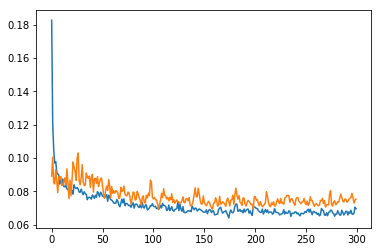

In [191]:
plt.plot(history.history["mean_squared_error"])
plt.plot(history.history["val_mean_squared_error"])

In [192]:
def generate_test_set_regression():
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_regression(300, 20)
    return [X_test, Y_test]

In [193]:
[X_test, Y_test] = generate_test_set_regression()

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


In [194]:
Y_pred=regressor.predict(X_test)

Visualize the prediction:

[[0.23325432 0.15415605]
 [0.5149824  0.45317341]
 [0.32182751 0.87390724]]


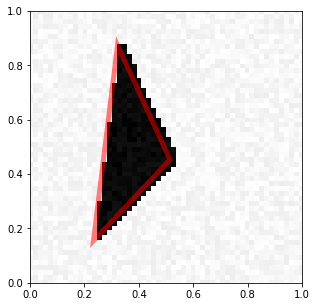

[[0.43085912 0.39329618]
 [0.43879294 0.47794563]
 [0.4281205  0.49273968]]


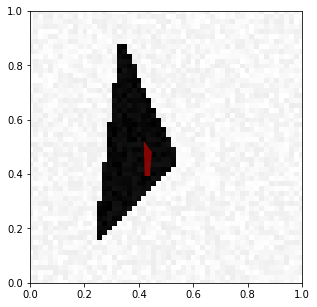

In [195]:
visualize_prediction(X_test[2], Y_test[2])
visualize_prediction(X_test[2], Y_pred[2])

In [198]:
X_Train = X_train.reshape([-1, 72,72,1])
X_re = X_re.reshape([-1, 72,72,1])

Normalize and apply the convulation model: 

In [199]:
from keras.layers import BatchNormalization

In [200]:
regressor2 = Sequential()

regressor2.add(Conv2D(256,(3,3),input_shape=(72,72,1,),padding="same", activation='relu'))
regressor2.add(BatchNormalization())
regressor2.add(MaxPooling2D(pool_size=(2,2)))

regressor2.add(Conv2D(256,(3,3),input_shape=(72,72,1,), padding="same",activation='relu'))
regressor2.add(BatchNormalization())
regressor2.add(MaxPooling2D(pool_size=(2,2)))

regressor2.add(Conv2D(256,(3,3),input_shape=(72,72,1,), padding="same",activation='relu'))
regressor2.add(BatchNormalization())
regressor2.add(MaxPooling2D(pool_size=(2,2)))


regressor2.add(Flatten())
regressor2.add(Dense(units=64, kernel_initializer="uniform", activation="relu"))
regressor2.add(BatchNormalization())
regressor2.add(Dense(units=6, kernel_initializer="uniform"))
regressor2.compile(loss='mse', optimizer='adam', metrics= ["mse"])
history=regressor2.fit(X_Train,Y_train,batch_size=32, validation_data=(X_re, Y_re),epochs=20)

Train on 300 samples, validate on 300 samples
Epoch 1/20
300/300 [==============================] - 124s 412ms/step - loss: 0.3367 - mean_squared_error: 0.3367 - val_loss: 0.4788 - val_mean_squared_error: 0.4788
Epoch 2/20
300/300 [==============================] - 117s 389ms/step - loss: 0.2812 - mean_squared_error: 0.2812 - val_loss: 0.4177 - val_mean_squared_error: 0.4177
Epoch 3/20
300/300 [==============================] - 109s 363ms/step - loss: 0.2583 - mean_squared_error: 0.2583 - val_loss: 0.3021 - val_mean_squared_error: 0.3021
Epoch 4/20
300/300 [==============================] - 102s 340ms/step - loss: 0.2359 - mean_squared_error: 0.2359 - val_loss: 0.2743 - val_mean_squared_error: 0.2743
Epoch 5/20
300/300 [==============================] - 99s 332ms/step - loss: 0.2090 - mean_squared_error: 0.2090 - val_loss: 0.2497 - val_mean_squared_error: 0.2497
Epoch 6/20
300/300 [==============================] - 101s 336ms/step - loss: 0.1772 - mean_squared_error: 0.1772 - val_loss:

In [201]:
X_Test = X_test.reshape([-1, 72,72,1])

In [202]:
Y_pred=regressor2.predict(X_Test)

Visualize the prediction:

[[0.94133439 0.93818117]
 [0.67661723 0.27556678]
 [0.36340393 0.33217252]]


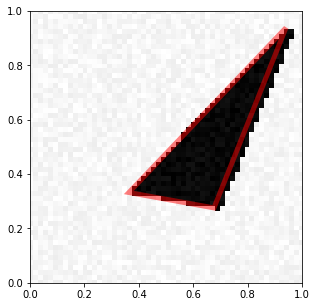

[[ 0.07798275 -0.05685088]
 [ 0.91880643  1.1643611 ]
 [ 0.7295503   0.04006678]]


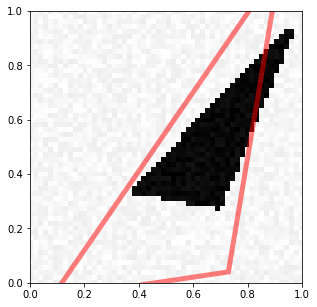

In [203]:
visualize_prediction(X_test[0], Y_test[0])
visualize_prediction(X_test[0], Y_pred[0])

## Denoise with an hourglass network

In [204]:
def generate_a_drawing_denoise(figsize, U, V, noise=0.0):
    fig = plt.figure(figsize=(figsize, figsize))
    ax = plt.subplot(111)
    plt.axis('Off')
    ax.set_xlim(0, figsize)
    ax.set_ylim(0, figsize)
    ax.fill(U, V, "k")
    fig.canvas.draw()
    imdata = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)[
        ::3].astype(np.float32)
    imdatan = imdata + noise * np.random.random(imdata.size)
    plt.close(fig)
    return imdatan, imdata

In [205]:
def generate_a_triangle_denoise(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        U = np.random.random(3)
        V = np.random.random(3)
    else:
        size = (0.3 + 0.7 * np.random.random()) * figsize / 2
        middle = figsize / 2
        U = (middle, middle + size, middle - size)
        V = (middle + size, middle - size, middle - size)
    imdatan, imdata = generate_a_drawing_denoise(figsize, U, V, noise)
    return [imdatan,imdata, [U[0], V[0], U[1], V[1], U[2], V[2]]]

In [206]:
def generate_a_rectangle_denoise(noise=0.0, free_location=False):
    figsize = 1.0
    U = np.zeros(4)
    V = np.zeros(4)
    if free_location:
        corners = np.random.random(4)
        top = max(corners[0], corners[1])
        bottom = min(corners[0], corners[1])
        left = min(corners[2], corners[3])
        right = max(corners[2], corners[3])
    else:
        side = (0.3 + 0.7 * np.random.random()) * figsize
        top = figsize / 2 + side / 2
        bottom = figsize / 2 - side / 2
        left = bottom
        right = top
    U[0] = U[1] = top
    U[2] = U[3] = bottom
    V[0] = V[3] = left
    V[1] = V[2] = right
    return generate_a_drawing_denoise(figsize, U, V, noise)

In [207]:
def generate_a_disk_denoise(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        center = np.random.random(2)
    else:
        center = (figsize / 2, figsize / 2)
    radius = (0.3 + 0.7 * np.random.random()) * figsize / 2
    N = 50
    U = np.zeros(N)
    V = np.zeros(N)
    i = 0
    for t in np.linspace(0, 2 * np.pi, N):
        U[i] = center[0] + np.cos(t) * radius
        V[i] = center[1] + np.sin(t) * radius
        i = i + 1
    return generate_a_drawing_denoise(figsize, U, V, noise)

In [208]:
def generate_dataset_denoise(nb_samples, noise=0.0, free_location=False):
    # Getting im_size:
    im_size = generate_a_rectangle_denoise()[0].shape[0]
    X = np.zeros([nb_samples, im_size])
    Y = np.zeros([nb_samples, im_size])
    print('Creating data:')
    for i in range(nb_samples):
        if i % 100 == 0:
            print(i)
        category = np.random.randint(3)
        if category == 0:
            X[i], Y[i] = generate_a_rectangle_denoise(noise, free_location)
        elif category == 1:
            X[i],Y[i] = generate_a_disk_denoise(noise, free_location)
        else:
            [X[i],Y[i], V] = generate_a_triangle_denoise(noise, free_location)
    X = (X + noise) / (255 + 2 * noise)
    Y = Y/255
    return [X, Y]

In [209]:
[X_train7,Y_train7]=generate_dataset_denoise(500,20,True)

Creating data:
0
100
200
300
400


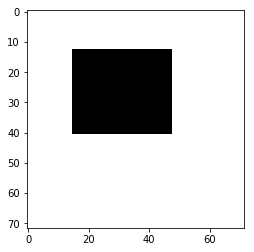

In [211]:
plt.imshow(Y_train7[400].reshape(IMAGE_SIZE, IMAGE_SIZE), cmap='gray')

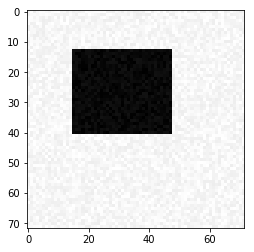

In [212]:
plt.imshow(X_train7[400].reshape(IMAGE_SIZE, IMAGE_SIZE), cmap='gray')

In [213]:
X_train7 = X_train7.reshape(X_train7.shape[0],72,72,1)
Y_train7 = Y_train7.reshape(Y_train7.shape[0],72,72,1)

In [214]:
from keras.layers import UpSampling2D

Create the convultional model: 

In [215]:
model7 = Sequential()
model7.add(Conv2D(32,(3, 3), activation='relu',padding = 'same' ,input_shape=(72,72,1)))
model7.add(MaxPooling2D(pool_size=(2, 2)))
model7.add(Conv2D(32,(3,3), activation = 'relu', padding = 'same'))
model7.add(MaxPooling2D(pool_size=(2,2)))

model7.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding = 'same'))
model7.add(UpSampling2D(size=(2, 2)))
model7.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding = 'same'))
model7.add(UpSampling2D(size=(2, 2)))
model7.add(Conv2D(1, kernel_size=(3, 3), activation='sigmoid', padding = 'same'))

In [216]:
model7.compile(optimizer='adadelta',loss='binary_crossentropy',metrics=['accuracy'])

In [217]:
model7.fit(X_train7, Y_train7, epochs=200, batch_size=64)

Epoch 1/200
500/500 [==============================] - 12s 25ms/step - loss: 0.4676 - acc: 0.8667
Epoch 2/200
500/500 [==============================] - 11s 22ms/step - loss: 0.2091 - acc: 0.9116
Epoch 3/200
500/500 [==============================] - 11s 21ms/step - loss: 0.1678 - acc: 0.9277
Epoch 4/200
500/500 [==============================] - 10s 21ms/step - loss: 0.1052 - acc: 0.9725
Epoch 5/200
500/500 [==============================] - 11s 23ms/step - loss: 0.0761 - acc: 0.9757
Epoch 6/200
500/500 [==============================] - 10s 20ms/step - loss: 0.0589 - acc: 0.9785
Epoch 7/200
500/500 [==============================] - 10s 20ms/step - loss: 0.0413 - acc: 0.9849
Epoch 8/200
500/500 [==============================] - 10s 21ms/step - loss: 0.0411 - acc: 0.9845
Epoch 9/200
500/500 [==============================] - 10s 20ms/step - loss: 0.0320 - acc: 0.9885
Epoch 10/200
500/500 [==============================] - 10s 20ms/step - loss: 0.0373 - acc: 0.9859
Epoch 11/200
500/50

500/500 [==============================] - 9s 19ms/step - loss: 0.0050 - acc: 0.9983
Epoch 85/200
500/500 [==============================] - 9s 19ms/step - loss: 0.0048 - acc: 0.9983
Epoch 86/200
500/500 [==============================] - 10s 20ms/step - loss: 0.0047 - acc: 0.9983
Epoch 87/200
500/500 [==============================] - 10s 19ms/step - loss: 0.0046 - acc: 0.9983
Epoch 88/200
500/500 [==============================] - 9s 18ms/step - loss: 0.0048 - acc: 0.9982
Epoch 89/200
500/500 [==============================] - 9s 18ms/step - loss: 0.0125 - acc: 0.9947
Epoch 90/200
500/500 [==============================] - 9s 18ms/step - loss: 0.0059 - acc: 0.9977
Epoch 91/200
500/500 [==============================] - 9s 18ms/step - loss: 0.0046 - acc: 0.9984
Epoch 92/200
500/500 [==============================] - 10s 19ms/step - loss: 0.0045 - acc: 0.9984
Epoch 93/200
500/500 [==============================] - 9s 18ms/step - loss: 0.0044 - acc: 0.9984
Epoch 94/200
500/500 [========

500/500 [==============================] - 9s 18ms/step - loss: 0.0027 - acc: 0.9991
Epoch 167/200
500/500 [==============================] - 9s 17ms/step - loss: 0.0027 - acc: 0.9991
Epoch 168/200
500/500 [==============================] - 8s 17ms/step - loss: 0.0027 - acc: 0.9991
Epoch 169/200
500/500 [==============================] - 8s 16ms/step - loss: 0.0026 - acc: 0.9991
Epoch 170/200
500/500 [==============================] - 8s 17ms/step - loss: 0.0026 - acc: 0.9991
Epoch 171/200
500/500 [==============================] - 9s 17ms/step - loss: 0.0042 - acc: 0.9982
Epoch 172/200
500/500 [==============================] - 9s 18ms/step - loss: 0.0076 - acc: 0.9968
Epoch 173/200
500/500 [==============================] - 9s 18ms/step - loss: 0.0039 - acc: 0.9984
Epoch 174/200
500/500 [==============================] - 9s 17ms/step - loss: 0.0027 - acc: 0.9991
Epoch 175/200
500/500 [==============================] - 9s 18ms/step - loss: 0.0026 - acc: 0.9991
Epoch 176/200
500/500 [=

In [218]:
Xmod = X_train7[9]

In [219]:
Xmod = Xmod.reshape(1,72,72,1)

Plot the prediction: 

In [220]:
prediction=model7.predict(Xmod)

In [221]:
prediction=prediction.reshape(72,72)

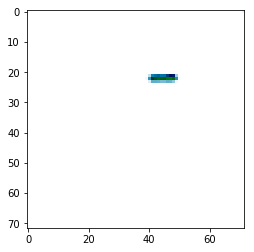

In [224]:
plt.imshow(prediction, cmap='ocean')

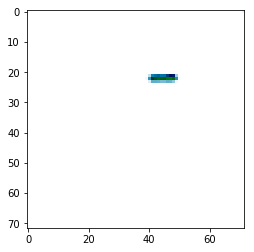

In [226]:
plt.imshow(prediction.reshape(72,72), cmap='ocean')